<a href="https://colab.research.google.com/github/malvarezgarcia1213-png/Project-I-Deep-Learning-Image-Classification-with-CNN/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assessment Components
1. Data Preprocessing:

- Data loading and preprocessing (e.g., normalization, resizing, augmentation).
- Create visualizations of some images, and labels.

In [51]:
import kagglehub

# Download latest version
zip_path = kagglehub.dataset_download("alessiocorrado99/animals10")
print("Dataset descargado en:", zip_path)

Using Colab cache for faster access to the 'animals10' dataset.
Dataset descargado en: /kaggle/input/animals10


In [56]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [57]:
dataset_dir = "/kaggle/input/animals10/raw-img"  # Ajusta según donde esté tu carpeta

# Diccionario de traducción italiano -> inglés
translate_to_english = {
    "cane": "dog",
    "gatto": "cat",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel"
}

In [58]:
# Data augmentation para el entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalizar pixeles
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2       # 20% de validación
)

# Para validación solo normalizamos
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [59]:
datagen = ImageDataGenerator(
    rescale=1./255,           # Normalización: convierte los valores de píxeles [0–255] → [0–1]
    validation_split=0.2,     # División: 80% entrenamiento / 20% validación
    rotation_range=25,        # Rotaciones aleatorias (augmentación)
    width_shift_range=0.2,    # Desplazamiento horizontal
    height_shift_range=0.2,   # Desplazamiento vertical
    shear_range=0.2,          # Transformación de corte
    zoom_range=0.2,           # Zoom aleatorio
    horizontal_flip=True,     # Volteo horizontal
    fill_mode='nearest'       # Cómo rellenar los píxeles vacíos tras una transformación
)

In [60]:
img_height, img_width = 128, 128
batch_size = 32

train_gen = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [61]:
train_gen.class_indices = {translate_to_english[k]: v for k, v in train_gen.class_indices.items()}
val_gen.class_indices   = {translate_to_english[k]: v for k, v in val_gen.class_indices.items()}

print("Clases en inglés:", train_gen.class_indices)

Clases en inglés: {'dog': 0, 'horse': 1, 'elephant': 2, 'butterfly': 3, 'chicken': 4, 'cat': 5, 'cow': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}


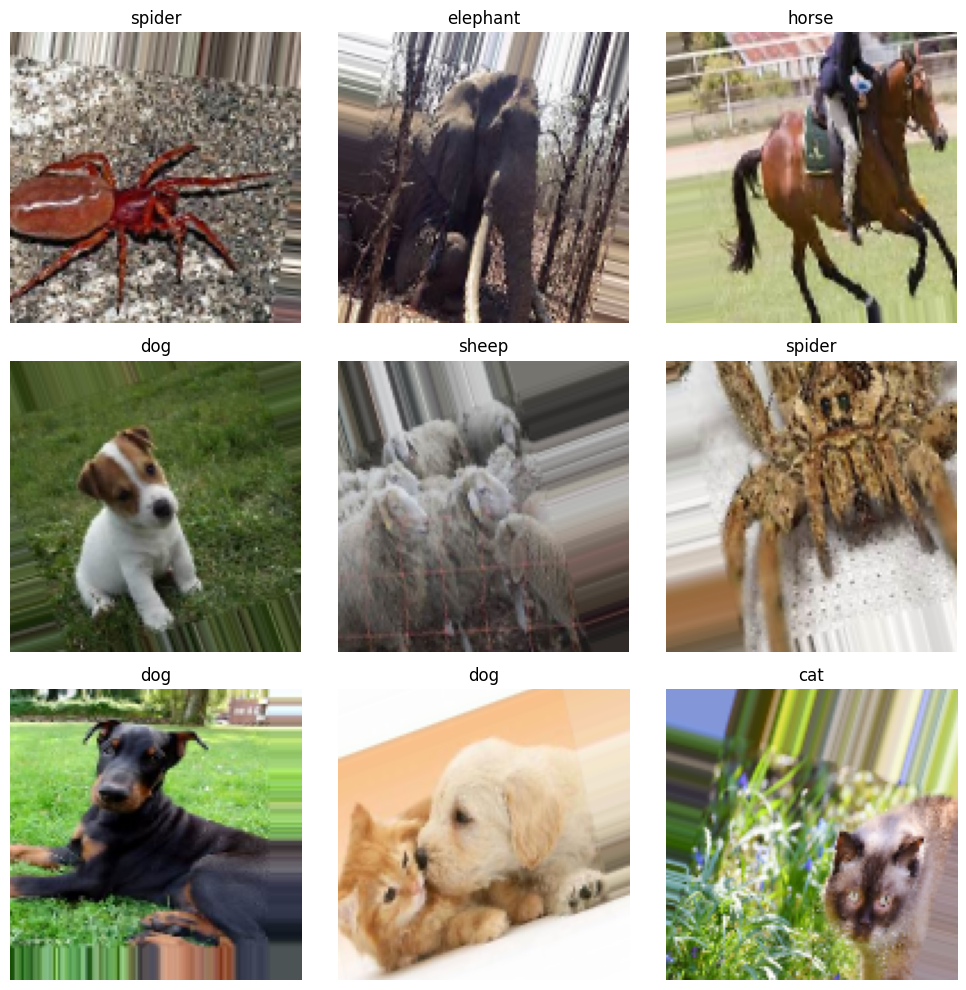

In [62]:
# Obtener un batch de imágenes y etiquetas
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    label_index = np.argmax(y_batch[i])
    label_name = list(train_gen.class_indices.keys())[label_index]
    plt.title(label_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

2 . Model Architecture

- Design a CNN architecture suitable for image classification.
- Include convolutional layers, pooling layers, and fully connected layers.

In [63]:
img_height, img_width = 128, 128
batch_size = 32

In [64]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [65]:
num_classes = 10  # 10 animales

model = models.Sequential([
    # --- Block 1 ---
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # --- Block 2 ---
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # --- Block 3 ---
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # --- Fully Connected ---
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # regularización para evitar overfitting
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,678,442 (33.11 MB)

 Trainable params: 8,678,442 (33.11 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,   # puedes aumentar si quieres
    batch_size=32
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 708s 1s/step - accuracy: 0.1806 - loss: 2.2359 - val_accuracy: 0.1864 - val_loss: 2.1797
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 669s 1s/step - accuracy: 0.2109 - loss: 2.1622 - val_accuracy: 0.2985 - val_loss: 1.9737
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 673s 1s/step - accuracy: 0.2771 - loss: 2.0238 - val_accuracy: 0.3337 - val_loss: 1.8661
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 668s 1s/step - accuracy: 0.3127 - loss: 1.9180 - val_accuracy: 0.3869 - val_loss: 1.7590
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 668s 1s/step - accuracy: 0.3783 - loss: 1.7915 - val_accuracy: 0.4752 - val_loss: 1.4820
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 661s 1s/step - accuracy: 0.4214 - loss: 1.6877 - val_accuracy: 0.5245 - val_loss: 1.3462
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 675s 1s/step - accuracy: 0.4653 - loss: 1.5756 - val_accuracy: 0.5487 - val_loss: 1.3000
Epoch 8/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 672s 1s/step - accuracy: 0.4848 - loss: 1.5162 - val_accu